# 1. SETTINGS

In [199]:
# settings for Google Colab
#from google.colab import drive
#drive.mount('/gdrive')
#import os
#os.chdir("/gdrive/My Drive/Colab Notebooks/DMC_2019/codes")

In [200]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
import copy
import scipy.stats
import os
import time

In [201]:
# helper functions
import functions
from functions import *

In [202]:
# pandas options
pd.set_option('display.max_columns', None)

In [203]:
# dark background style
plt.style.use('dark_background')

In [204]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [205]:
# garbage collection
import gc
gc.enable()

# 2. DATA PREPARATION

In [206]:
# import CSV
df = pd.read_csv('../data/data_v3.csv')
print(df.shape)

(500000, 13)


In [207]:
# target variable
target = 'fraud'

In [208]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(1879, 13)
(498121, 13)


In [209]:
# target variable
y = train[target]
del train[target], test[target]

# 3. MODELING

### PARAMETERS

In [210]:
# drop bad features
excluded_feats = ['id']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(1879, 11)


In [211]:
### PARAMETERS

# settings
cores = 12
seed  = 815

# cross-validation
num_folds = 5
shuffle   = True

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [212]:
# placeholders
clfs = []
valid_profit = np.zeros(num_folds) 
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])
importances  = pd.DataFrame()

In [213]:
# SMOTE settings
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 23, n_jobs = 10, sampling_strategy = 0.1)

### CROSS-VALIDATION

In [266]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    tmp_test = test[features]

    ## remove outliers
    #out_idx = (np.abs(scipy.stats.zscore(trn_x)) < 3).all(axis = 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    # scale data
    scaler   = RobustScaler()
    trn_x    = pd.DataFrame(scaler.fit_transform(trn_x),      columns = features)
    val_x    = pd.DataFrame(scaler.transform(val_x),          columns = features)
    tmp_test = pd.DataFrame(scaler.transform(test[features]), columns = features)
    
    # augment training data with SMOTE
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
    
    # factor decomposition
    tmp_features = copy.deepcopy(features)
    #if False:
    #    decomp = FactorAnalysis(n_components = 11)
    #    decomp.fit(trn_x)
    #    trn_x = decomp.transform(trn_x)
    #    val_x = decomp.transform(val_x)
    #    tmp_test = decomp.transform(tmp_test)
    #    tmp_features = ['pc'+str(i) for i in range(decomp.n_components)]
    
    # add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # mean target encoding
    #trn_x, val_x, tmp_test = mean_target_encoding(trn_x, val_x, test, features = ['trustLevel'], target = 'fraud', folds = 5)
    #features = [f for f in trn_x.columns if f not in excluded_feats]
        
    # train lightGBM
    clf = LogisticRegression(penalty = 'l1', C = 1)
    clf = clf.fit(trn_x, trn_y)
    clfs.append(clf)
    
    # predict validation from the best iteration
    val_preds = clf.predict_proba(val_x)[:, 1]

    # save predictions
    preds_oof[val_idx]    = clf.predict_proba(val_x)[:, 1]
    valid_profit[n_fold]  = prediction_reward(val_y, preds_oof[val_idx])[1]
    preds_test           += clf.predict_proba(tmp_test)[:, 1] / folds.n_splits 
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: PROFIT = %.0f' % (n_fold + 1, valid_profit[n_fold]))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = np.sum(valid_profit)
print('--------------------------------')
print('TOTAL PROFIT = %.0f' % cv_perf)
print('--------------------------------')

--------------------------------
FOLD 1: PROFIT = 35
--------------------------------

--------------------------------
FOLD 2: PROFIT = 50
--------------------------------

--------------------------------
FOLD 3: PROFIT = 25
--------------------------------

--------------------------------
FOLD 4: PROFIT = 20
--------------------------------

--------------------------------
FOLD 5: PROFIT = 80
--------------------------------

--------------------------------
TOTAL PROFIT = 210
--------------------------------


In [267]:
##### RECHECK PROFIT  
prediction_reward(y, preds_oof)


###### TRACKING RESULTS (5 folds, strat = True, seed = 815)

# V1:                  230 => 280
# V2: remove outiers:  230 => 270
# V3: add sclaing:     240 => 285
# V4: use SMOTE:       235 => 275

('profit', 210.0, True)

### CUTOFF OPTIMIZATION

- optimal cutoff = 0.3600
- optimal profit = 275.0000


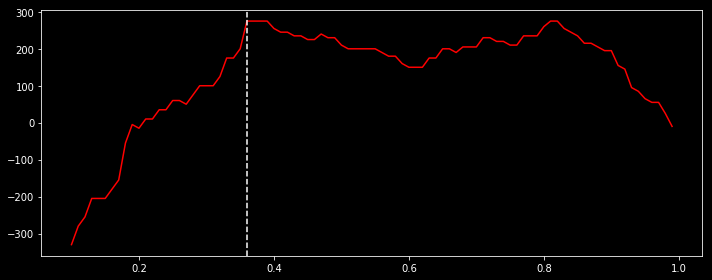

In [268]:
##### OPTIMIZE CUTOFF

# set step
step = 100

# search
cutoffs = []
profits = []
for i in range(0, step):
    cutoffs.append(i / step)
    profits.append(recompute_reward(y, preds_oof, cutoff = cutoffs[i]))
        
# results
plt.figure(figsize = (10,4))
sns.lineplot(x = cutoffs[10:step], y = profits[10:step], color = 'red')
plt.tight_layout()
plt.axvline(x = cutoffs[np.argmax(profits)], color = 'white', linestyle = '--')
print('- optimal cutoff = %.4f' % cutoffs[np.argmax(profits)])
print('- optimal profit = %.4f' % profits[np.argmax(profits)])

# update performance
cv_perf = recompute_reward(y, preds_oof, cutoff = cutoffs[np.argmax(profits)])

# 4. SUBMISSION

In [255]:
# file name
model = 'logit_v4'
perf  = str(round(cv_perf, 0).astype('int'))
name  = model + '_' + perf

In [256]:
# export OOF preds
oof = pd.DataFrame({'id': train['id'], 'fraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,id,fraud
0,lab_0,1.962580e-19
1,lab_1,3.513855e-24
2,lab_2,9.889274e-15
3,lab_3,7.044548e-19
4,lab_4,5.837561e-22


In [257]:
# check submission
sub = pd.DataFrame({'id': test['id'], 'fraud': preds_test})
sub['fraud'][sub['fraud'] >  cutoffs[np.argmax(profits)]] = 1
sub['fraud'][sub['fraud'] <= cutoffs[np.argmax(profits)]] = 0
sub['fraud'] = sub['fraud'].astype('int')
sub.head()

,id,fraud
1879,unlab_0,0
1880,unlab_1,0
1881,unlab_2,0
1882,unlab_3,0
1883,unlab_4,0


In [258]:
# export submission
sub = sub[['fraud']]
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(498121, 1)

In [259]:
# check correlation with previous submission
prev_sub = pd.read_csv('../submissions/lgb_v8_375.csv')
cor = np.sum(prev_sub[target] == sub.reset_index()[target]) / len(sub)
print("Share of the same predictions: " + str(np.round(cor, 6)))

Share of the same predictions: 0.981231
